Step 1: Load Libraries and Data

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, r2_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
    
# fetch dataset 
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468) 
  
# data (as pandas dataframes) 
X = online_shoppers_purchasing_intention_dataset.data.features 
y = online_shoppers_purchasing_intention_dataset.data.targets 

# metadata 
print(online_shoppers_purchasing_intention_dataset.metadata) 
  
# variable information 
print(online_shoppers_purchasing_intention_dataset.variables) 

# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

# Preview the combined DataFrame
print(df.head())

{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'ID': 367, 'type': 'NATIVE', 'title': 'Real-time prediction of online shoppers’ pur

Step 2: Exploratory Data Analysis (EDA)


Data Shape
--------------------------------------------------
 (12330, 18)

Data Types
--------------------------------------------------
 Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Data Preview
--------------------------------------------------
    Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0           

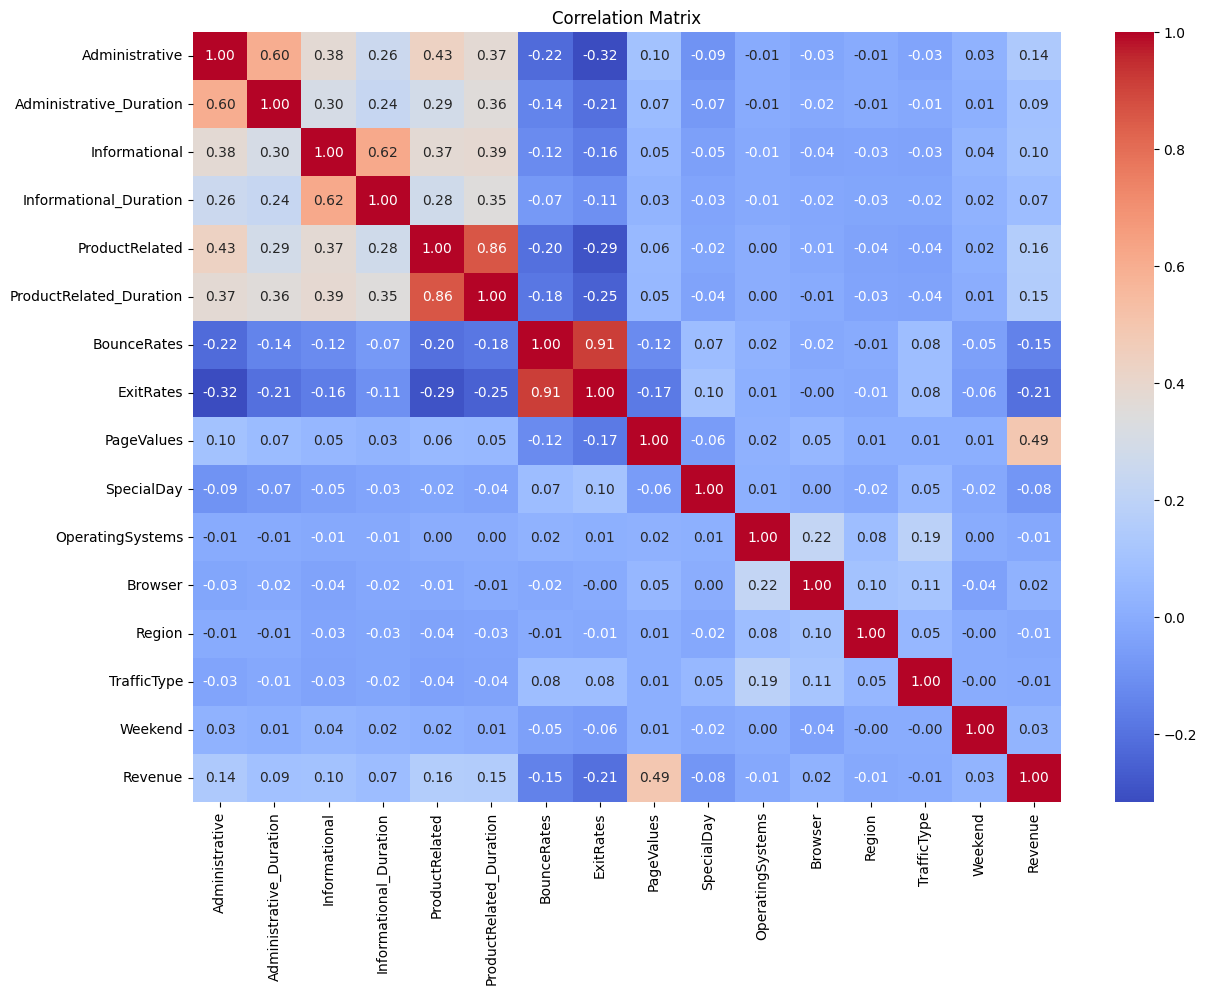

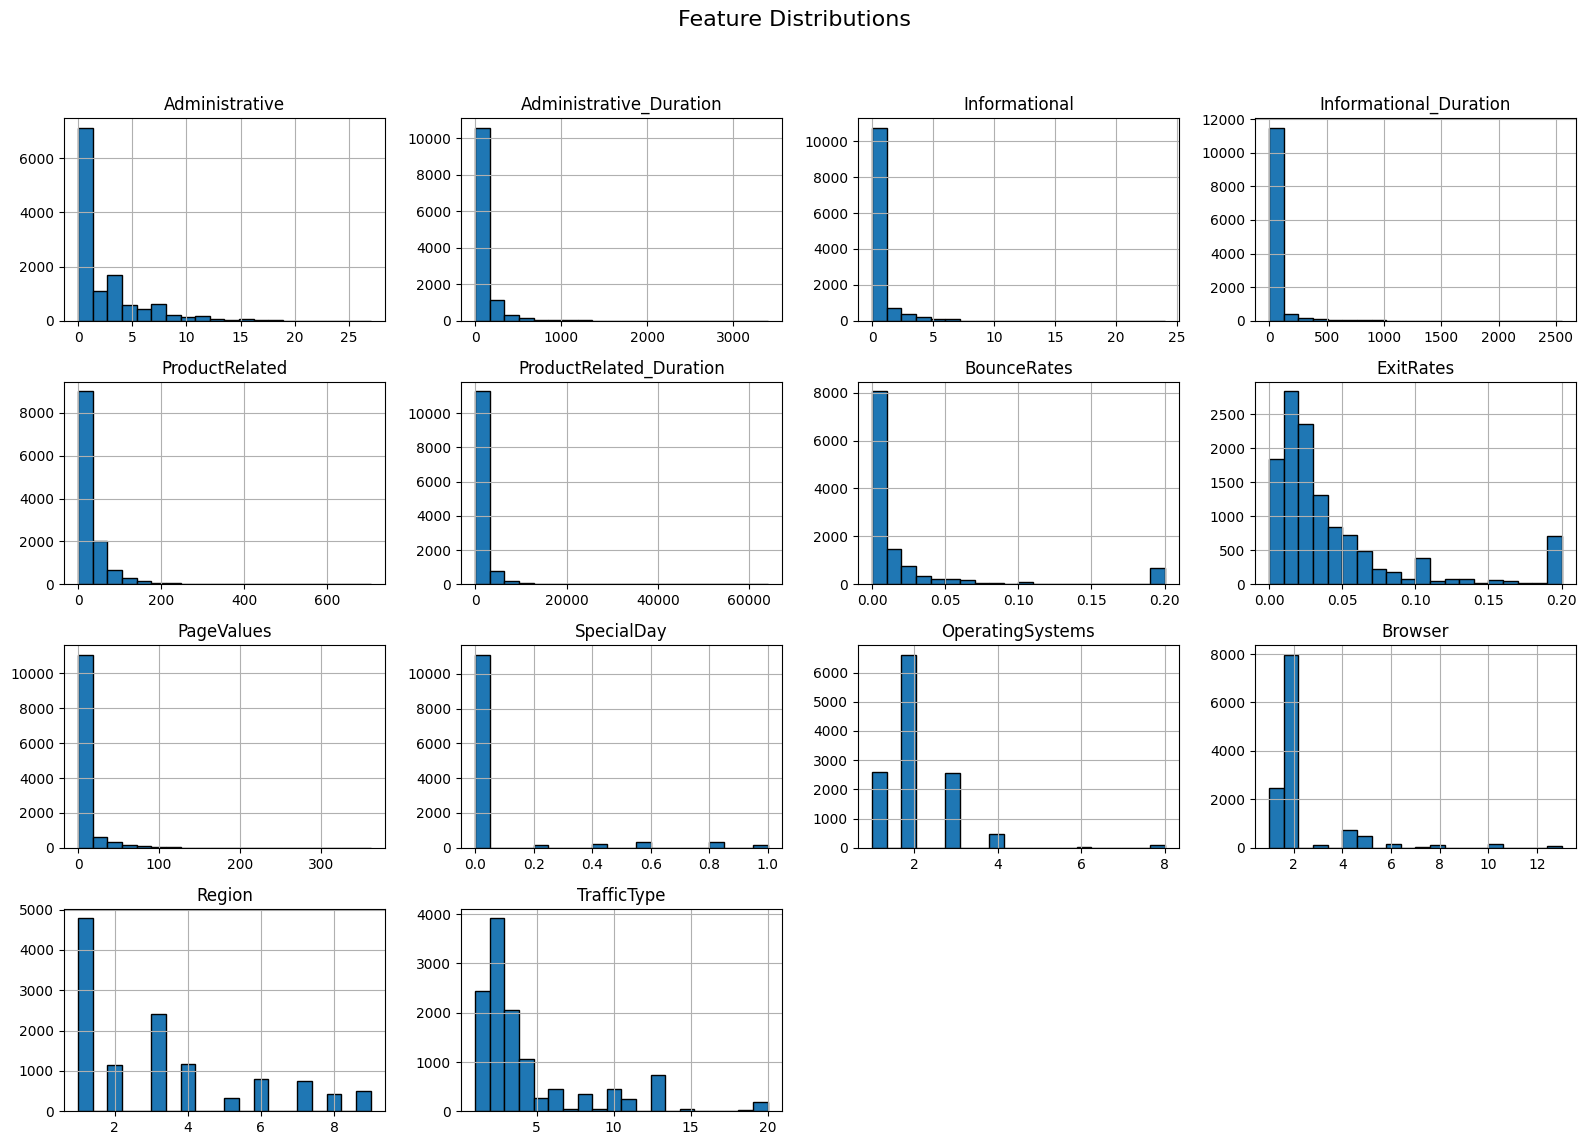

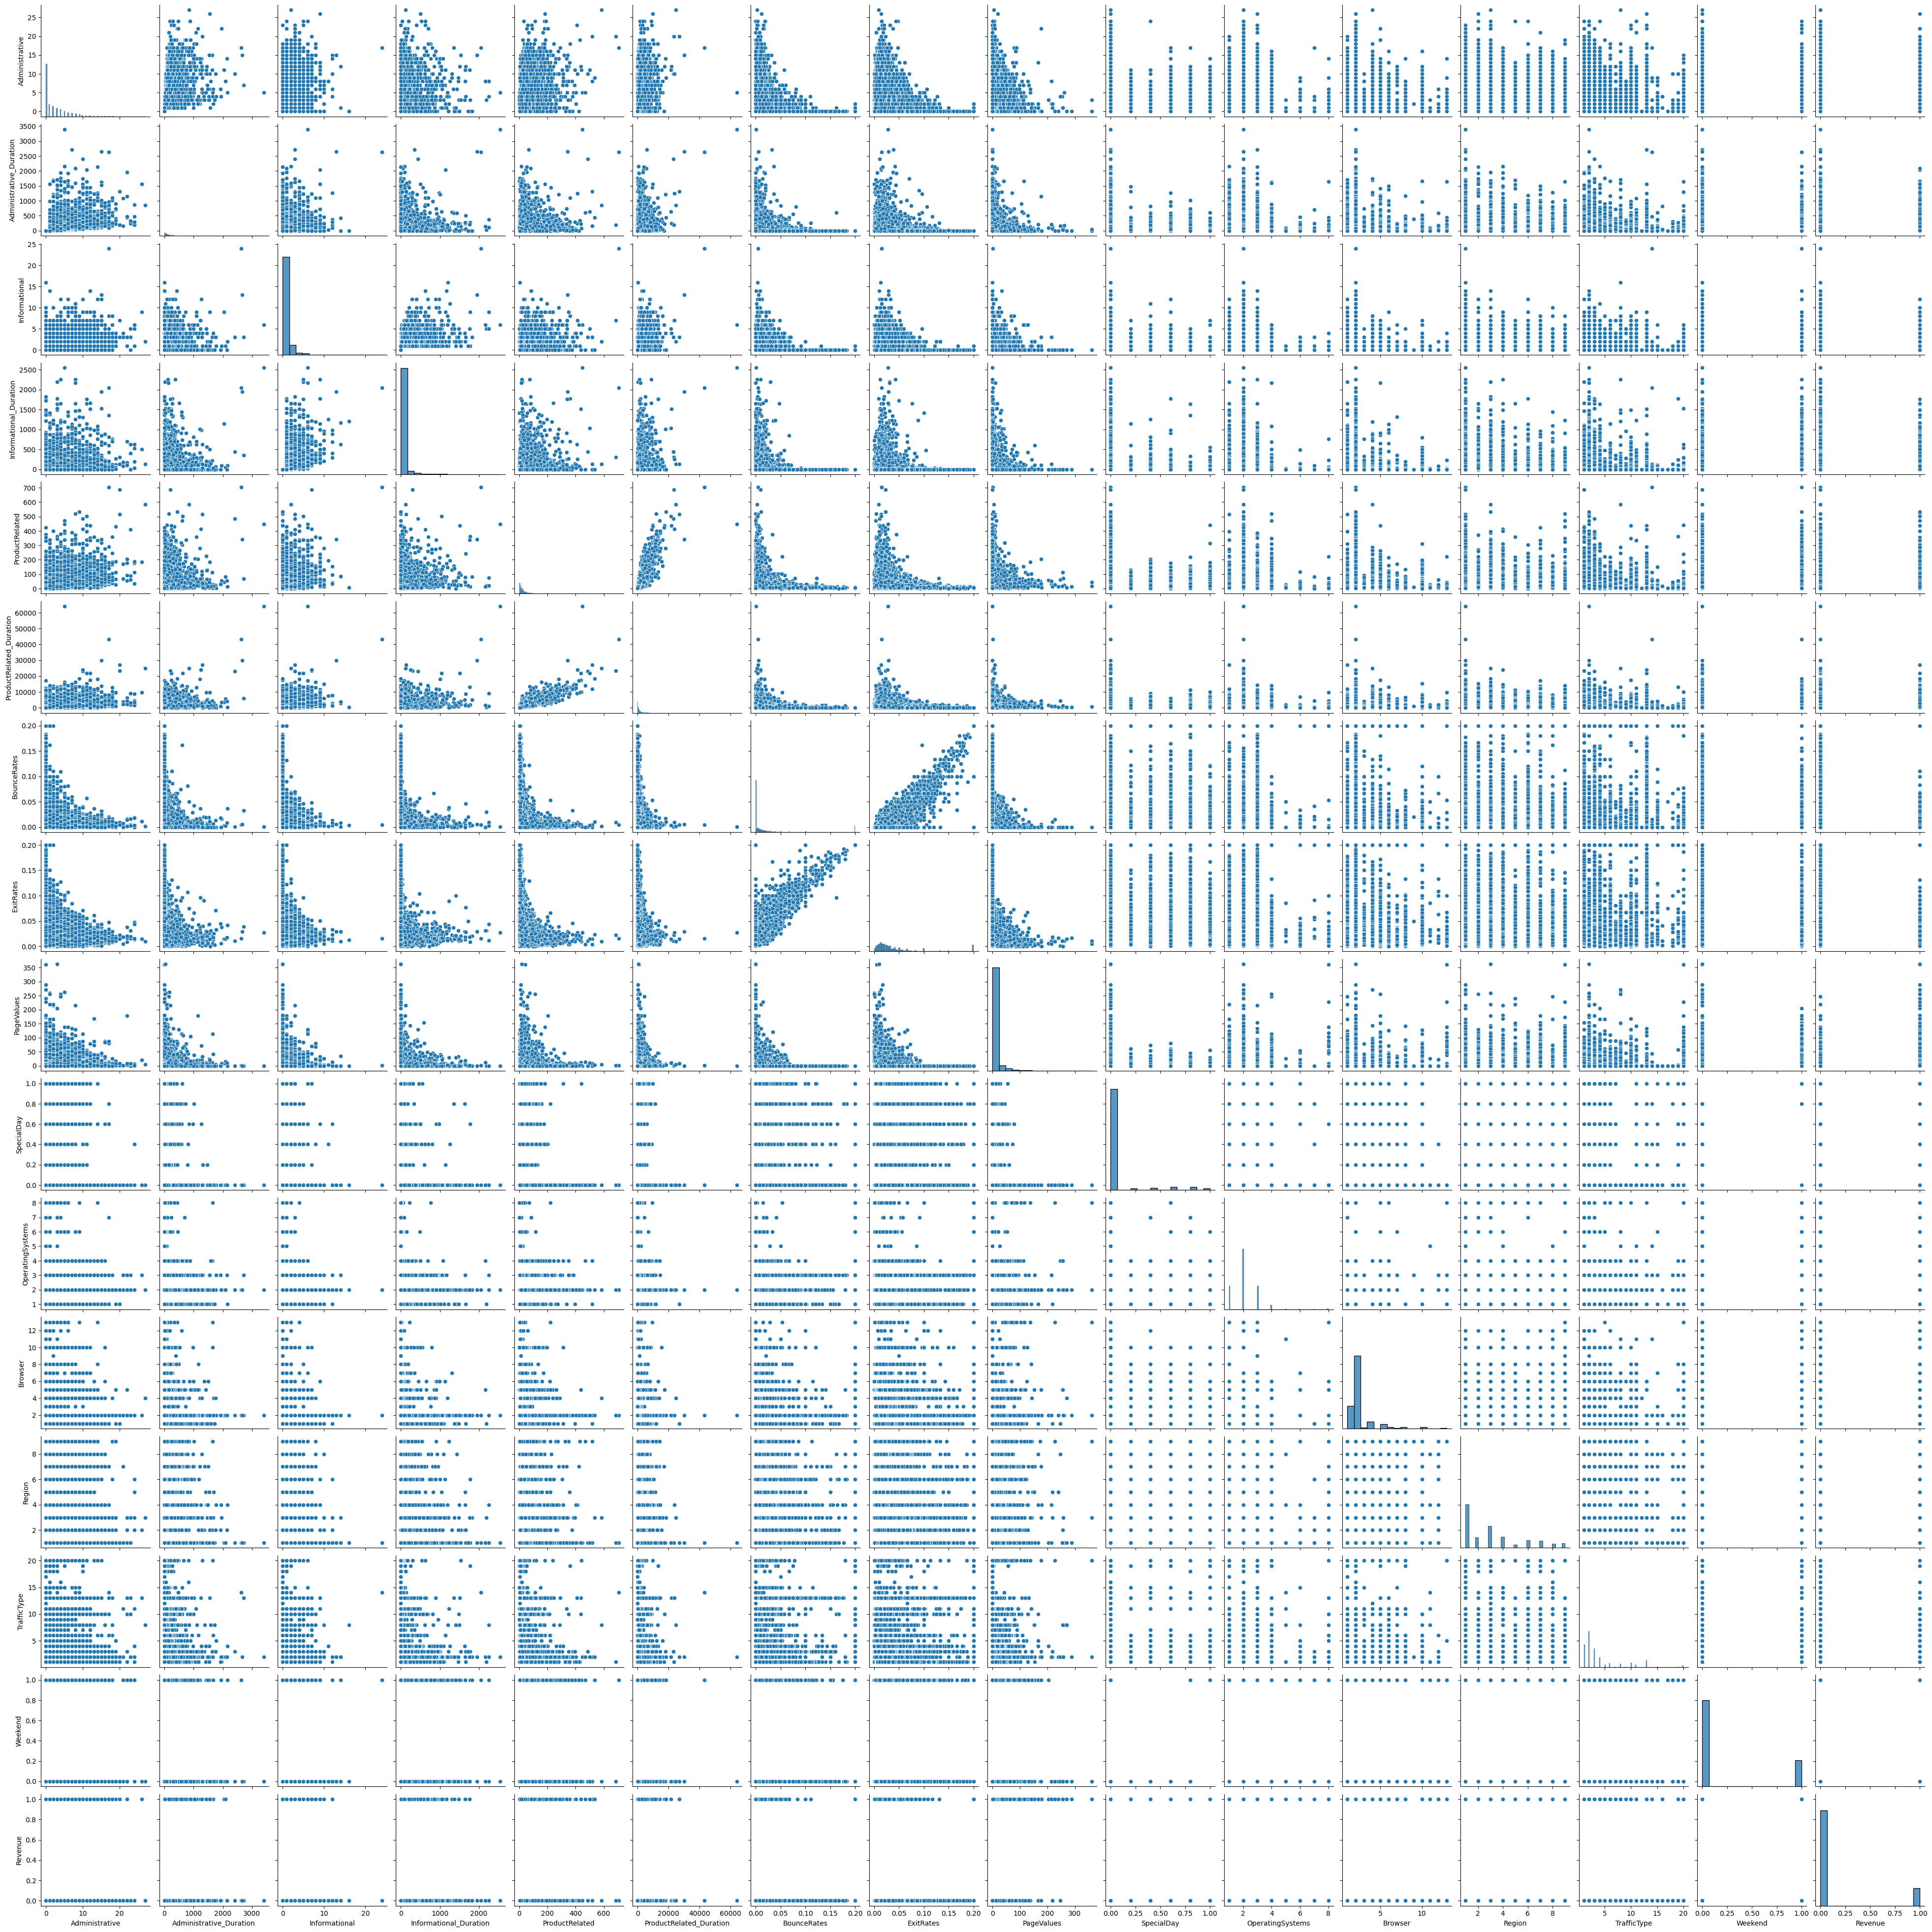

Numerical columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
Categorical columns: ['Month', 'VisitorType', 'Weekend', 'Revenue']


In [3]:
#Initial EDA
print("\nData Shape\n"+("-"*50)+"\n",df.shape)
print("\nData Types\n"+("-"*50)+"\n",df.dtypes)
print("\nData Preview\n"+("-"*50)+"\n",df.head())
print("\nData Info\n"+("-"*50)+"\n",df.info())
print("\nData Description\n"+("-"*50)+"\n",df.describe)

#Mean, Median, Mode, Standard Deviation
print("\nMean\n"+("-"*50)+"\n",df.mean(numeric_only=True))
print("\nMedian\n"+("-"*50)+"\n",df.median(numeric_only=True))
print("\nMode\n"+("-"*50)+"\n",df.mode(numeric_only=True))
print("\nStandard Deviation\n"+("-"*50)+"\n",df.std(numeric_only=True))

#Find Relationships
# Covariance Matrix - see if things move in same or opposite direction
cov_matrix = df.cov(numeric_only=True)
cov_unstacked = cov_matrix.where(~np.eye(cov_matrix.shape[0], dtype=bool)).unstack() # Remove diagonal (self covariance)
top_cov = cov_unstacked.dropna().abs().sort_values(ascending=False).drop_duplicates() # Drop NaNs and sort by absolute covariance value descending
print("\nTop 10 Covariance pairs:") # Show top 10 covariance pairs
print(top_cov.head(10))

# Correlation Matrix - check relationship strength
corr_matrix = df.corr(numeric_only=True).abs()
corr_unstacked = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool)).unstack()
top_corr = corr_unstacked.dropna().sort_values(ascending=False).drop_duplicates()
print("\nTop 10 Correlations:")
print(top_corr.head(10))
# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show

# Dataframe Plot Distributions
df.hist(bins=20, figsize=(16, 12), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Dataframe Pairplot
sns.pairplot(df)
plt.show()

#Differentiate between numerical and categorical columns
numerical_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object','bool']).columns.tolist()
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Step 3: Data Cleaning & Feature Engineering

In [4]:
#Handle Missing Values
df_imputed = df.copy()

# 1. Check missing values (should be none)
print("Missing values per column:\n", df_imputed.isnull().sum())

# 2. Check duplicates
duplicates = df_imputed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df_imputed = df_imputed.drop_duplicates()

Missing values per column:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64
Number of duplicate rows: 125


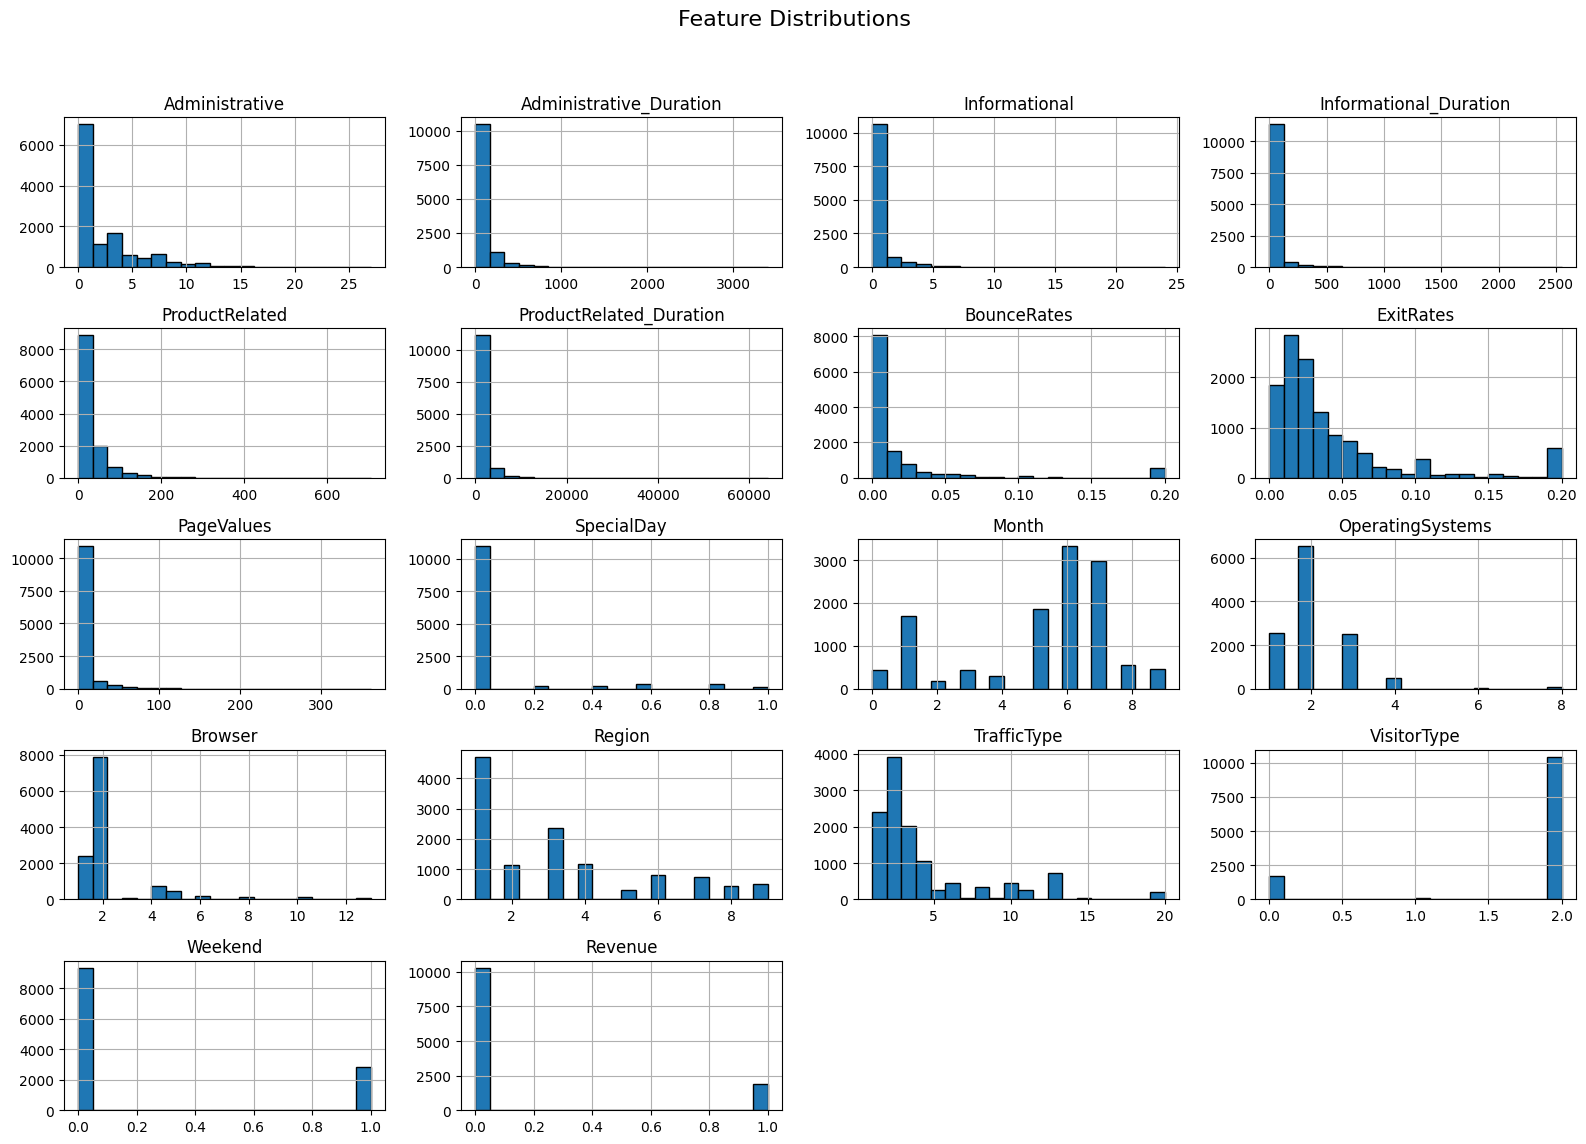

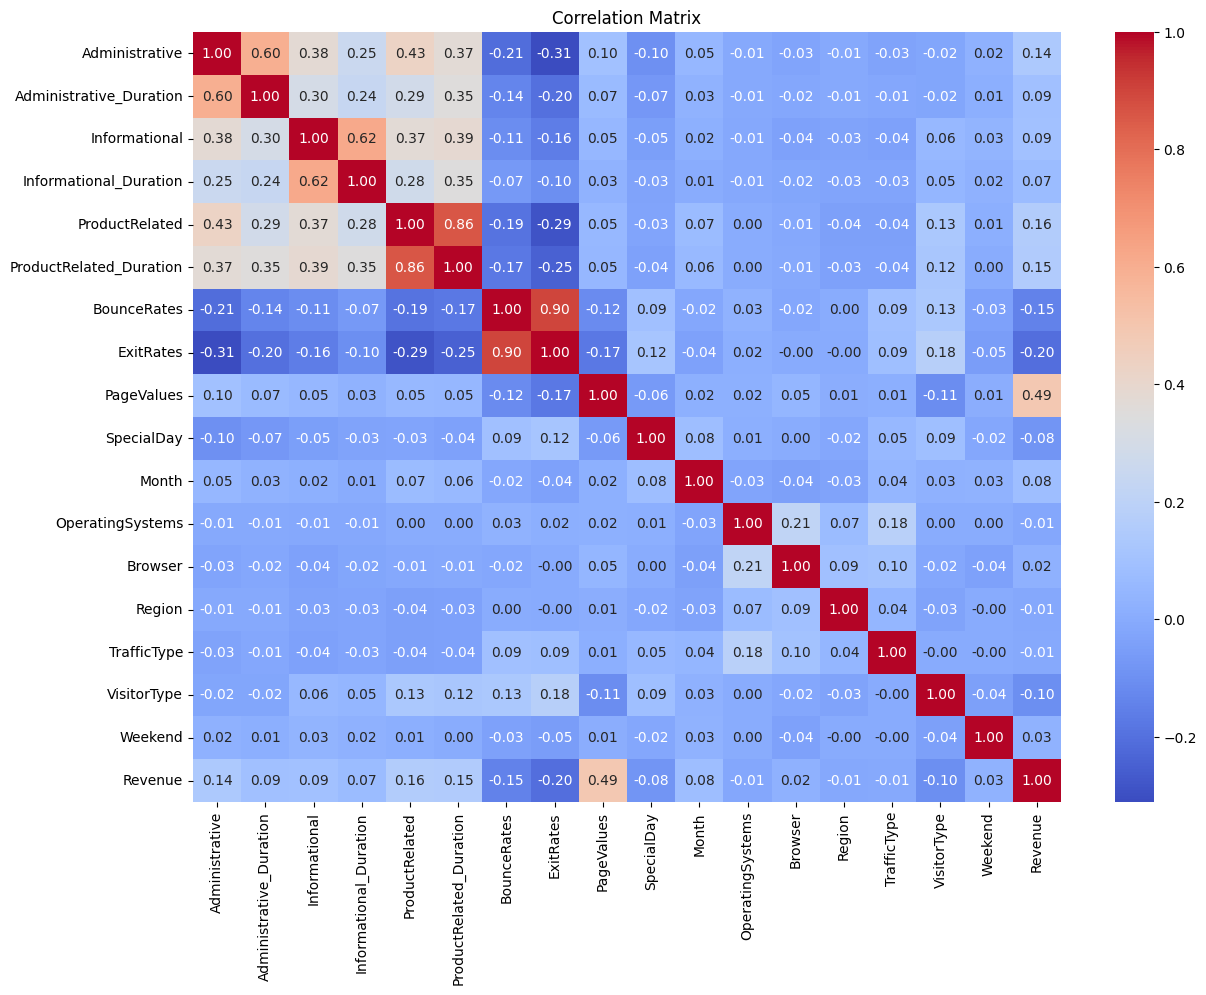


Top 10 Covariance pairs:
Administrative_Duration  ProductRelated_Duration    120470.509410
ProductRelated_Duration  Informational_Duration      94093.687380
                         ProductRelated              73645.983995
Administrative_Duration  Informational_Duration       5954.405428
ProductRelated_Duration  Administrative               2372.779780
ProductRelated           Administrative_Duration      2270.524638
PageValues               ProductRelated_Duration      1823.425588
Informational_Duration   ProductRelated               1760.074251
Informational            ProductRelated_Duration       945.315376
Administrative           Administrative_Duration       354.945208
dtype: float64

Top 10 Correlations:
BounceRates              ExitRates                  0.902144
ProductRelated_Duration  ProductRelated             0.860330
Informational            Informational_Duration     0.618648
Administrative           Administrative_Duration    0.600457
PageValues               Revenue 

In [5]:
# Convert boolean 'Weekend' to int if needed
df_imputed['Weekend'] = df_imputed['Weekend'].astype(int)

# Apply Label Encoding to categorical variables
le = LabelEncoder()
for col in categorical_cols:
    df_imputed[col] = le.fit_transform(df_imputed[col])


# Separate features and target
X = df_imputed.drop('Revenue', axis=1)
y = df_imputed['Revenue'].astype(int)  # assuming Revenue is boolean True/False

# 4. Scaling numeric features
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# Dataframe Plot Distributions
df_imputed.hist(bins=20, figsize=(16, 12), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_imputed.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Covariance Matrix - see if things move in same or opposite direction
cov_matrix = df_imputed.cov(numeric_only=True)
cov_unstacked = cov_matrix.where(~np.eye(cov_matrix.shape[0], dtype=bool)).unstack() # Remove diagonal (self covariance)
top_cov = cov_unstacked.dropna().abs().sort_values(ascending=False).drop_duplicates() # Drop NaNs and sort by absolute covariance value descending
print("\nTop 10 Covariance pairs:") # Show top 10 covariance pairs
print(top_cov.head(10))

# Correlation Matrix - check relationship strength
corr_matrix = df_imputed.corr(numeric_only=True).abs()
corr_unstacked = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool)).unstack()
top_corr = corr_unstacked.dropna().sort_values(ascending=False).drop_duplicates()
print("\nTop 10 Correlations:")
print(top_corr.head(10))

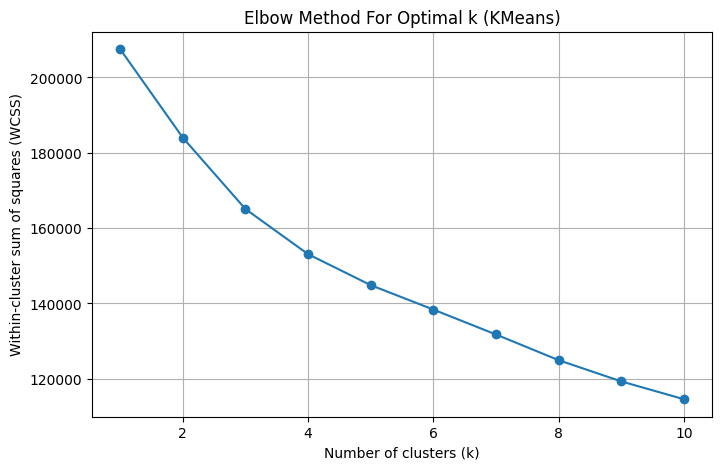

Classification Models Evaluation:
Random Forest: Accuracy=0.9017, F1=0.6437, R2=0.2546, ROC AUC=0.9221241171561744
Logistic Regression: Accuracy=0.8876, F1=0.5203, R2=0.1477, ROC AUC=0.8839868921861961
Naive Bayes: Accuracy=0.7985, F1=0.5199, R2=-0.5281, ROC AUC=0.8374146669109117
Decision Tree: Accuracy=0.8571, F1=0.5578, R2=-0.0834, ROC AUC=0.7428230648673952


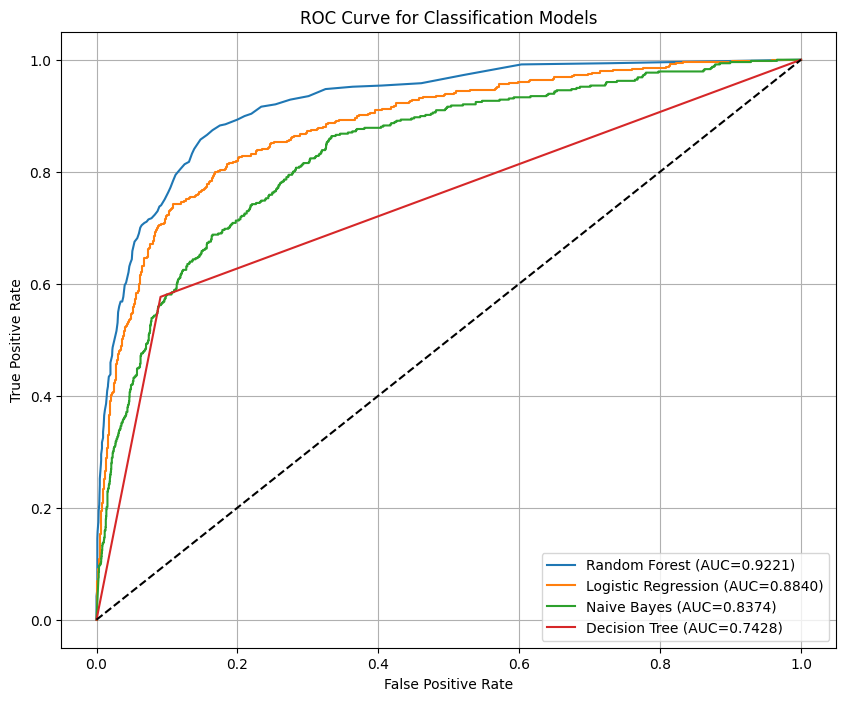


Clustering Models Evaluation:
KMeans: Silhouette Score=0.2581, Adjusted Rand Index=0.0983
Agglomerative Clustering: Silhouette Score=0.2204, Adjusted Rand Index=0.0758


In [6]:

# Train/test split for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Classification models including Naive Bayes and Decision Tree
classification_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=2, random_state=42),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=2)
}

# -------------------------
# Elbow plot for KMeans
wcss = []  # Within cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k (KMeans)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.grid(True)
plt.show()

# -------------------------
# Classification evaluation

print("Classification Models Evaluation:")
plt.figure(figsize=(10, 8))  # For ROC curves

for name, model in classification_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Obtain probability scores if available for ROC AUC and ROC curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # Note: R2 usually not used for classification
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}, R2={r2:.4f}, ROC AUC={roc_auc if roc_auc else 'N/A'}")
    
    # Plot ROC curve if probabilities available
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")

if any(hasattr(m, 'predict_proba') or hasattr(m, 'decision_function') for m in classification_models.values()):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Classification Models')
    plt.legend()
    plt.grid(True)
    plt.show()


# -------------------------
# Clustering evaluation

print("\nClustering Models Evaluation:")
for name, model in clustering_models.items():
    cluster_labels = model.fit_predict(X)
    
    sil_score = silhouette_score(X, cluster_labels)
    ari = adjusted_rand_score(y, cluster_labels)
    
    print(f"{name}: Silhouette Score={sil_score:.4f}, Adjusted Rand Index={ari:.4f}")


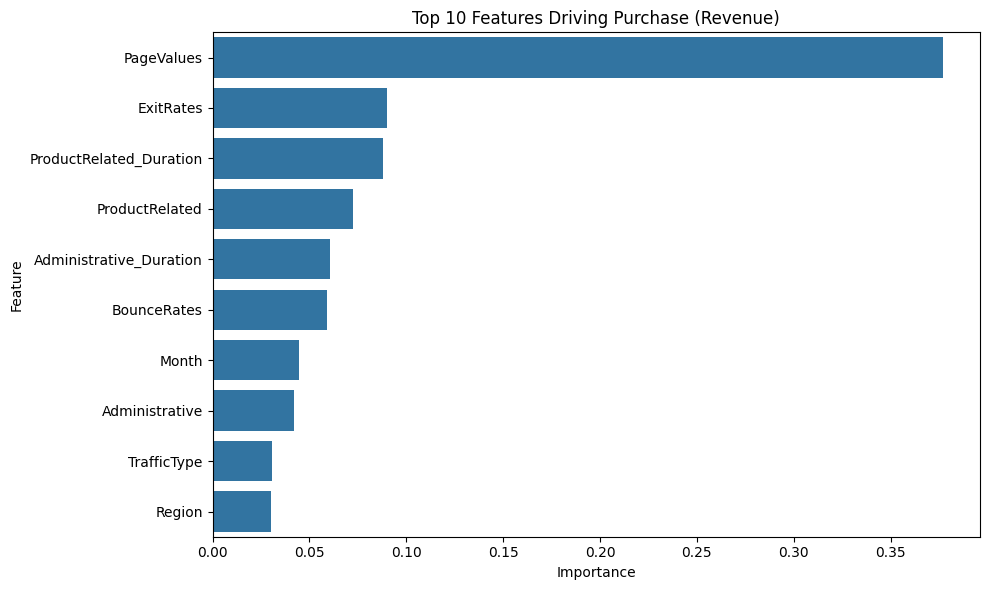

In [8]:
# After fitting the RF model
rf_model = classification_models['Random Forest']
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X.columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create and plot
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Top 10 Features Driving Purchase (Revenue)')
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import adjusted_rand_score

for name, model in clustering_models.items():
    cluster_labels = model.fit_predict(X)
    ari = adjusted_rand_score(y, cluster_labels)
    print(f"{name} ARI score vs Revenue: {ari:.4f}")


KMeans ARI score vs Revenue: 0.0983
Agglomerative Clustering ARI score vs Revenue: 0.0758


Top Drivers of Revenue (Top Features & Intrepretation)

- PageValues being important likely means: Users who engage with pages tied to transactions or conversions are more likely to purchase.
- PageValues was the top predictor of purchasing intention, suggesting that high-value content pages (e.g., pricing, cart) are critical touchpoints. Efforts to improve those could increase conversions.”
- ExitRates, AdministrativeDuration, or ProductRelated time may reflect decision hesitation or buyer confidence.


Key Takeaways:
Objective: Predict whether a user will make a purchase.
Dataset Description: UCI Online Shopper’s Purchasing Intention dataset (12,330 sessions).
Target Variable: Revenue (True/False)
Best Model: Random Forest (Accuracy: 90.17%, F1: 0.64, ROC AUC: 0.92)
Top Predictors of Revenue: PageValues, ExitRates, ProductRelated, Month, etc.
Insights: Behavioral indicators like time on site, page value, and bounce rate play a key role in conversion.
Business Recommendations: Optimize high-value pages, reduce bounce rates, personalize based on session behavior.